In [1]:
!pip install sentence-transformers annoy numpy pandas lshashpy3 matplotlib --quiet

In [292]:
from sentence_transformers import SentenceTransformer
# from user_models import UploadedFile
# import os
# import docx2txt
# from app import db
from annoy import AnnoyIndex
# import re
import numpy as np
import pandas as pd

model = SentenceTransformer("all-MiniLM-L6-v2")

paraphrased_articles = pd.read_csv("paraphrased_articles.csv")
translated = pd.read_csv("translated.csv")
gpt_paraphrases = pd.read_csv("chatgpt_paraphrases.csv")

pairs = list(zip(translated["text"], translated["en"]))
pairs += list(zip(paraphrased_articles["Abstract"], paraphrased_articles["ParaphrasedAbstract"]))
pairs += list(zip(paraphrased_articles["Introduction"], paraphrased_articles["ParaphraseIntroduction"]))
n_gpt_paraphrases = 150000
original = gpt_paraphrases["text"][:n_gpt_paraphrases]
paraphrase = gpt_paraphrases["paraphrases"].apply(lambda x: x.split("'")[1])[:n_gpt_paraphrases]
pairs += list(zip(original, paraphrase))
match_offset = len(pairs)

pairs = [pair[0] for pair in pairs] + [pair[1] for pair in pairs]
data = model.encode(pairs, show_progress_bar=True, convert_to_numpy=True)
print(data.shape)

Batches: 100%|██████████| 9648/9648 [03:43<00:00, 43.23it/s]


(308722, 384)


In [184]:
import timeit
res = []
def benchmark_brute_force(dataset_size = 28000):
    dataset = np.concatenate((data[:dataset_size//2], data[match_offset:match_offset+dataset_size//2]))
    def brute_force():
        results = []
        for vec in dataset[:1000]:
            prod = vec @ dataset.transpose() # calculate all dot products
            results.append(np.argpartition(prod, -2)[-2:])
        return results

    def calculate_accuracy(res):
        results = np.array(res)
        return (np.sum(results[:,0] + dataset_size//2 == results[:,1]) + np.sum(results[:,0] == results[:,1] + dataset_size//2)) / len(results)

    time = timeit.timeit(brute_force, number=3) / 3
    res = brute_force()
    accuracy = calculate_accuracy(res)
    return time, accuracy

for i in range(5000, 100000, 1000):
    res.append((i, *benchmark_brute_force(dataset_size=i)))
print(res)

[(5000, 0.20686393066716846, 0.981), (10000, 0.5670526806691972, 0.976), (15000, 0.7597686666704249, 0.976), (20000, 0.9169224446668522, 0.975), (25000, 1.2180590696661966, 0.976), (30000, 1.9028715416643536, 0.975), (35000, 1.766191722335255, 0.975), (40000, 2.0461127083350825, 0.975), (45000, 2.3142080973339034, 0.975), (50000, 2.179429166664098, 0.976), (55000, 2.393789361003049, 0.974), (60000, 2.4796018193349787, 0.973), (65000, 2.6823881806679615, 0.973), (70000, 3.5352473333332455, 0.973), (75000, 3.3318718333369666, 0.973), (80000, 3.8124602220001784, 0.974), (85000, 3.897471708332887, 0.973), (90000, 3.888330388998535, 0.973), (95000, 4.3207341113350894, 0.972)]


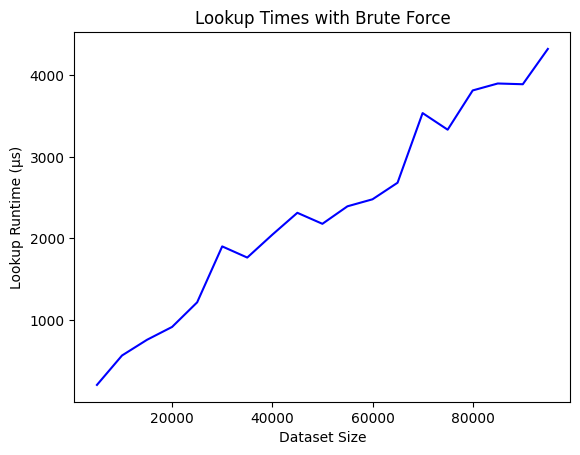

In [185]:
import matplotlib.pyplot as plt
times = []
setup_times = []
dataset_sizes = []
for i, r in enumerate(res):
    dataset_sizes.append(r[0])
    times.append(r[1] * 1000)
fig, ax = plt.subplots()
ax.set_title("Lookup Times with Brute Force")
ax.plot(dataset_sizes, times, label='Lookup times', color='blue')
ax.set_xlabel('Dataset Size')
ax.set_ylabel('Lookup Runtime (μs)')
plt.show()

In [306]:
import timeit
acc = []
annoy = AnnoyIndex(384, "dot")

def benchmark_annoy(num_trees = 4, search_k = 8, dataset_size = 28000):
    dataset = np.concatenate((data[:dataset_size//2], data[match_offset:match_offset+dataset_size//2]))
    def setup():
        global annoy
        annoy = AnnoyIndex(384, "dot")
        for i, vec in enumerate(dataset):
            annoy.add_item(i, vec)
        annoy.build(num_trees, n_jobs=-1)

    def similarity_search():
        results = []
        for i in range(1000):
            results.append(annoy.get_nns_by_item(i, 2, search_k = search_k, include_distances=True)[0])
        return results

    def calculate_accuracy(res):
        results = np.array(res)
        return (np.sum(results[:,0] + dataset_size//2 == results[:,1]) + np.sum(results[:,0] == results[:,1] + dataset_size//2)) / len(results)

    setup_time = timeit.timeit(setup, number=1)
    time = timeit.timeit(similarity_search, number=1)
    sim = similarity_search()
    accuracy = calculate_accuracy(sim)
    return setup_time, time, accuracy

# res = []
# for search_k in range(100, 4000, 300):
#     setup_time, time, accuracy = benchmark_annoy(num_trees = int(search_k**0.5), search_k = search_k)
#     print("Search_K:", search_k)
#     print("Setup Runtime:", setup_time, "seconds")
#     print("Average Runtime:", time, "seconds")
#     print("Accuracy:", accuracy * 100, "%")
#     res.append((search_k, setup_time, time, accuracy))
# print(res)

dataset_res = []
for dataset_size in range(5000, 100000, 5000):
    setup_time, time, accuracy = benchmark_annoy(num_trees = 30, search_k = 1000, dataset_size=dataset_size)
    print("Dataset Size:", dataset_size)
    print("Setup Runtime:", setup_time, "seconds")
    print("Average Runtime:", time, "seconds")
    print("Accuracy:", accuracy * 100, "%")
    dataset_res.append((dataset_size, setup_time, time, accuracy))
for dataset_size in range(100000, 200001, 20000):
    setup_time, time, accuracy = benchmark_annoy(num_trees = 30, search_k = 1000, dataset_size=dataset_size)
    print("Dataset Size:", dataset_size)
    print("Setup Runtime:", setup_time, "seconds")
    print("Average Runtime:", time, "seconds")
    print("Accuracy:", accuracy * 100, "%")
    dataset_res.append((dataset_size, setup_time, time, accuracy))
print(dataset_res)

Dataset Size: 5000
Setup Runtime: 0.19511316600255668 seconds
Average Runtime: 0.28597004200855736 seconds
Accuracy: 96.89999999999999 %
Dataset Size: 10000
Setup Runtime: 0.5456035840034019 seconds
Average Runtime: 0.3394785410055192 seconds
Accuracy: 95.5 %
Dataset Size: 15000
Setup Runtime: 0.5454051249980694 seconds
Average Runtime: 0.36103558300237637 seconds
Accuracy: 94.89999999999999 %
Dataset Size: 20000
Setup Runtime: 0.8015770420024637 seconds
Average Runtime: 0.37245691700081807 seconds
Accuracy: 94.19999999999999 %
Dataset Size: 25000
Setup Runtime: 1.1491657079895958 seconds
Average Runtime: 0.45238870799948927 seconds
Accuracy: 94.0 %
Dataset Size: 30000
Setup Runtime: 1.374059291993035 seconds
Average Runtime: 0.40783966600429267 seconds
Accuracy: 93.8 %
Dataset Size: 35000
Setup Runtime: 1.5157795419945614 seconds
Average Runtime: 0.501848208004958 seconds
Accuracy: 92.7 %
Dataset Size: 40000
Setup Runtime: 1.7186712910042843 seconds
Average Runtime: 0.442515499991714 

In [187]:
res

[(100, 0.7383699374986463, 0.09697208299621707, 0.692),
 (400, 0.8568776669999352, 0.2016029169972171, 0.855),
 (700, 0.9844054999994114, 0.2911454999994021, 0.906),
 (1000, 0.9995033124941983, 0.38339943749451777, 0.934),
 (1300, 1.1111657915025717, 0.47115620849945117, 0.95),
 (1600, 1.160688145995664, 0.5525551044993335, 0.959),
 (1900, 1.2014196875024936, 0.6308410625060787, 0.964),
 (2200, 1.2646614164987113, 0.7262490415014327, 0.968),
 (2500, 1.372182792001695, 0.796532833497622, 0.967),
 (2800, 1.3223613334994297, 0.8676487499978975, 0.968),
 (3100, 1.3798417915022583, 0.9308878749943688, 0.969),
 (3400, 1.4560789999959525, 1.0048468125023646, 0.971),
 (3700, 1.4677490210015094, 1.1368976250014384, 0.971)]

In [307]:
dataset_res

[(5000, 0.19511316600255668, 0.28597004200855736, 0.969),
 (10000, 0.5456035840034019, 0.3394785410055192, 0.955),
 (15000, 0.5454051249980694, 0.36103558300237637, 0.949),
 (20000, 0.8015770420024637, 0.37245691700081807, 0.942),
 (25000, 1.1491657079895958, 0.45238870799948927, 0.94),
 (30000, 1.374059291993035, 0.40783966600429267, 0.938),
 (35000, 1.5157795419945614, 0.501848208004958, 0.927),
 (40000, 1.7186712910042843, 0.442515499991714, 0.909),
 (45000, 1.8358503750059754, 0.4211224589962512, 0.902),
 (50000, 2.6897407499927795, 0.48775541700888425, 0.904),
 (55000, 2.5771660419995897, 0.538733958004741, 0.902),
 (60000, 2.7960392910026712, 0.42776470800163224, 0.904),
 (65000, 2.5914887090038974, 0.4453543749987148, 0.907),
 (70000, 3.0070638750039507, 0.47167920898937155, 0.887),
 (75000, 3.36664141700021, 0.45796583300398197, 0.892),
 (80000, 3.6885174170020036, 0.47732787499262486, 0.89),
 (85000, 4.092211750001297, 0.47793033299967647, 0.893),
 (90000, 4.788465541001642, 0

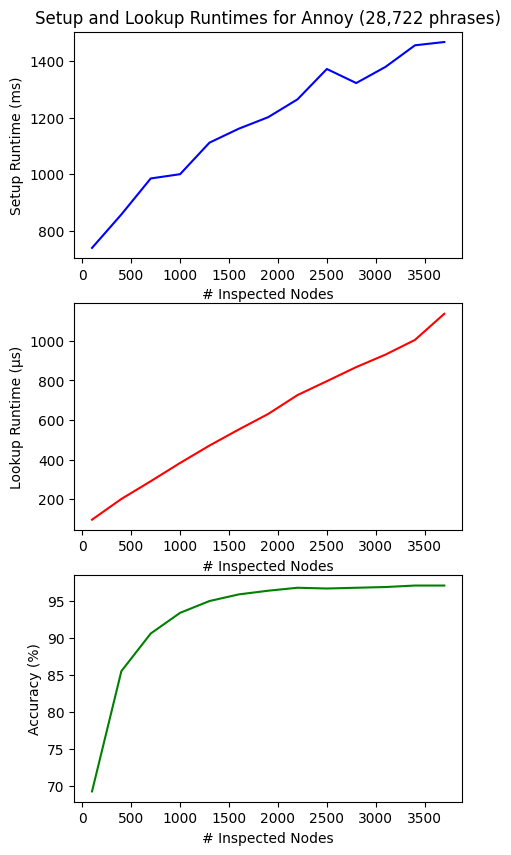

In [189]:
import matplotlib.pyplot as plt

times = []
setup_times = []
search_ks = []
acc = []
for i, r in enumerate(res):
    search_ks.append(r[0])
    setup_times.append(r[1] * 1000)
    times.append(r[2] * 1000)
    acc.append(r[3] * 100)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,10))
ax1.set_title("Setup and Lookup Runtimes for Annoy (28,722 phrases)")
ax1.plot(search_ks, setup_times, label='Setup times', color='blue')
ax2.plot(search_ks, times, label='Lookup times', color='red')
ax3.plot(search_ks, acc, label='Lookup times', color='green')
ax2.set_xlabel('# Inspected Nodes')
ax1.set_xlabel('# Inspected Nodes')
ax3.set_xlabel('# Inspected Nodes')
ax1.set_ylabel('Setup Runtime (ms)')
ax2.set_ylabel('Lookup Runtime (μs)')
ax3.set_ylabel('Accuracy (%)')
plt.show()

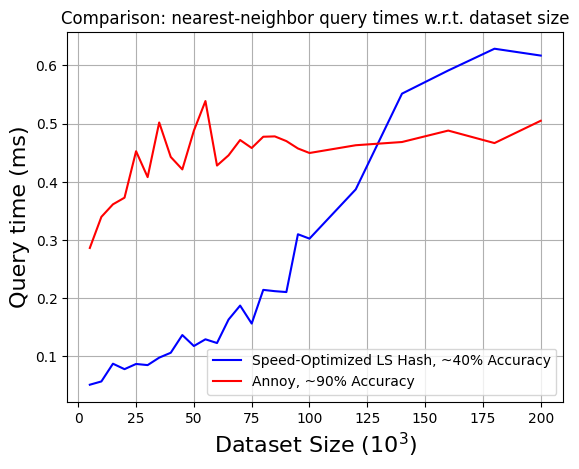

In [356]:
import matplotlib.pyplot as plt
hi1 = np.array([(5000, 0.19511316600255668, 0.28597004200855736, 0.969),
 (10000, 0.5456035840034019, 0.3394785410055192, 0.955),
 (15000, 0.5454051249980694, 0.36103558300237637, 0.949),
 (20000, 0.8015770420024637, 0.37245691700081807, 0.942),
 (25000, 1.1491657079895958, 0.45238870799948927, 0.94),
 (30000, 1.374059291993035, 0.40783966600429267, 0.938),
 (35000, 1.5157795419945614, 0.501848208004958, 0.927),
 (40000, 1.7186712910042843, 0.442515499991714, 0.909),
 (45000, 1.8358503750059754, 0.4211224589962512, 0.902),
 (50000, 2.6897407499927795, 0.48775541700888425, 0.904),
 (55000, 2.5771660419995897, 0.538733958004741, 0.902),
 (60000, 2.7960392910026712, 0.42776470800163224, 0.904),
 (65000, 2.5914887090038974, 0.4453543749987148, 0.907),
 (70000, 3.0070638750039507, 0.47167920898937155, 0.887),
 (75000, 3.36664141700021, 0.45796583300398197, 0.892),
 (80000, 3.6885174170020036, 0.47732787499262486, 0.89),
 (85000, 4.092211750001297, 0.47793033299967647, 0.893),
 (90000, 4.788465541001642, 0.4698450830037473, 0.893),
 (95000, 4.0935777080012485, 0.4571515419956995, 0.883),
 (100000, 4.32238862500526, 0.4493575420056004, 0.886),
 (120000, 5.5059048749972135, 0.46269937499891967, 0.858),
 (140000, 6.5327165000053355, 0.4682534999883501, 0.867),
 (160000, 7.437537667006836, 0.48792670799593907, 0.872),
 (180000, 8.814877041993896, 0.46643099999346305, 0.866),
 (200000, 9.321719041996403, 0.504817875000299, 0.858)])[:,2]
hi2 = np.array([(5000, 0.2755557089985814, 0.050660000008065253, 0.337),
 (10000, 0.6212607500056038, 0.05629554200277198, 0.343),
 (15000, 0.8109947909979383, 0.08682599999883678, 0.333),
 (20000, 1.089337291996344, 0.07742845799657516, 0.345),
 (25000, 1.3297171250014799, 0.08637616600026377, 0.336),
 (30000, 1.503482542000711, 0.08441804199537728, 0.34),
 (35000, 1.7901926250051474, 0.09725820801395457, 0.344),
 (40000, 2.4954847089975374, 0.10567749998881482, 0.309),
 (45000, 2.5232209999958286, 0.13613620899559464, 0.327),
 (50000, 3.1101797909941524, 0.11725270899478346, 0.336),
 (55000, 2.983320500003174, 0.12880241699167527, 0.343),
 (60000, 3.249404540998512, 0.12239845900330693, 0.309),
 (65000, 4.200065541997901, 0.1628079170041019, 0.339),
 (70000, 4.02034362500126, 0.1868220000033034, 0.362),
 (75000, 4.940676666999934, 0.1558794169977773, 0.328),
 (80000, 4.625869082999998, 0.21384299999044742, 0.345),
 (85000, 5.576998250006, 0.2116327500116313, 0.327),
 (90000, 5.4830308749951655, 0.2100867919943994, 0.341),
 (95000, 5.66326154100534, 0.3095690409973031, 0.357),
 (100000, 6.496734166998067, 0.30200308399798814, 0.341),
 (120000, 8.366133542003809, 0.3867607090069214, 0.342),
 (140000, 11.057538208013284, 0.5514646250056103, 0.323),
 (160000, 12.029644374997588, 0.5912983330053976, 0.318),
 (180000, 26.888364166996325, 0.6287688329903176, 0.345),
 (200000, 18.764969875002862, 0.6169782080105506, 0.326)])
dataset_sizes = hi2[:,0] / 1000
hi2 = hi2[:,2]
setup_times = []
times = []
acc = []
for i, r in enumerate(dataset_res):
    setup_times.append(r[1] * 1000)
    times.append(r[2])
    acc.append(r[3] * 100)
fig, ax2 = plt.subplots()
ax2.set_title("Comparison: nearest-neighbor query times w.r.t. dataset size")
# ax1.plot(dataset_sizes, setup_times, label='Total indexing time (s)', color='blue')
ax2.plot(dataset_sizes, hi2, label='Speed-Optimized LS Hash, ~40% Accuracy', color='blue')
ax2.plot(dataset_sizes, hi1, label='Annoy, ~90% Accuracy', color='red')
# ax1.set_xlabel('Dataset Size')
ax2.set_xlabel('Dataset Size ($10^3$)')
# ax1.set_ylabel('Total indexing time (s)')
ax2.set_ylabel('Query time (ms)')
plt.rc('axes', labelsize=14) 
# ax1.grid()
ax2.grid()
ax2.legend()
plt.show()

In [344]:
print(np.dot(data[9], data[4]))

0.047097895


In [317]:
from lshashpy3 import LSHash
lsh = LSHash(4, 384, num_hashtables=4)

def benchmark_hashing(hash_size = 64, hash_tables = 4, dataset_size=28000):
    dataset = np.concatenate((data[:dataset_size//2], data[match_offset:match_offset+dataset_size//2]))
    def hash_setup():
        global lsh
        lsh = LSHash(hash_size, 384, num_hashtables=hash_tables)
        for i, vec in enumerate(dataset):
            lsh.index(vec, extra_data=i)

    def hash_similarity_search():
        results = []
        for i, vec in enumerate(dataset[:1000]):
            query = lsh.query(vec, num_results=2, distance_func="cosine")
            results.append((i, (query[1][0][1] if len(query) > 1 else -1)))
        return results

    def calculate_accuracy(res):
        results = np.array(res)
        return (np.sum(results[:,0] + dataset_size//2 == results[:,1]) + np.sum(results[:,0] == results[:,1] + dataset_size//2)) / len(results)

    setup_time = timeit.timeit(hash_setup, number=1)
    time = timeit.timeit(hash_similarity_search, number=1)
    r = hash_similarity_search()
    accuracy = calculate_accuracy(r)
    return setup_time, time, accuracy

# res = []
# for i in range(10,24,2):
#     hash_size = i
#     setup_time, time, accuracy = benchmark_hashing(hash_size=hash_size)
#     setup_time2, time2, accuracy2 = benchmark_hashing(hash_size=hash_size)
#     print("Hash size:", hash_size)
#     print("Setup Runtime:", (setup_time + setup_time2)/2, "seconds")
#     print("Average Runtime:", (time+time2)/2, "seconds")
#     print("Accuracy:", (accuracy+accuracy2)/2 * 100, "%")
#     res.append((hash_size, setup_time, time, accuracy))
# print(res)

# hashres = []
# for i in range(2,12,2):
#     hash_size = 10
#     setup_time, time, accuracy = benchmark_hashing(hash_size=hash_size, hash_tables=i)
#     setup_time2, time2, accuracy2 = benchmark_hashing(hash_size=hash_size, hash_tables=i)
#     print("Num tables:", i)
#     print("Setup Runtime:", (setup_time + setup_time2)/2, "seconds")
#     print("Average Runtime:", (time+time2)/2, "seconds")
#     print("Accuracy:", (accuracy+accuracy2)/2 * 100, "%")
#     hashres.append((i, setup_time, time, accuracy))
# print(hashres)

dataset_res = []
# for dataset_size in range(5000, 100000, 5000):
#     setup_time, time, accuracy = benchmark_hashing(hash_size=16, hash_tables=4, dataset_size=dataset_size)
#     print("Dataset size:", dataset_size)
#     print("Setup Runtime:", setup_time, "seconds")
#     print("Average Runtime:", time, "seconds")
#     print("Accuracy:", accuracy * 100, "%")
#     dataset_res.append((dataset_size, setup_time, time, accuracy))
for dataset_size in range(120000, 200001, 20000):
    setup_time, time, accuracy = benchmark_hashing(hash_size=16, hash_tables=4, dataset_size=dataset_size)
    print("Dataset size:", dataset_size)
    print("Setup Runtime:", setup_time, "seconds")
    print("Average Runtime:", time, "seconds")
    print("Accuracy:", accuracy * 100, "%")
    dataset_res.append((dataset_size, setup_time, time, accuracy))
print(dataset_res)

Dataset size: 120000
Setup Runtime: 6.557247874996392 seconds
Average Runtime: 0.3867607090069214 seconds
Accuracy: 33.7 %
Dataset size: 140000
Setup Runtime: 9.960000709004817 seconds
Average Runtime: 0.7514646250056103 seconds
Accuracy: 33.0 %
Dataset size: 160000
Setup Runtime: 11.315314374995069 seconds
Average Runtime: 0.5912983330053976 seconds
Accuracy: 34.1 %
Dataset size: 180000
Setup Runtime: 13.41329675000452 seconds
Average Runtime: 0.6287688329903176 seconds
Accuracy: 35.4 %
Dataset size: 200000
Setup Runtime: 15.50503795799159 seconds
Average Runtime: 0.6169782080105506 seconds
Accuracy: 34.1 %
[(120000, 6.557247874996392, 0.3867607090069214, 0.337), (140000, 9.960000709004817, 0.7514646250056103, 0.33), (160000, 11.315314374995069, 0.5912983330053976, 0.341), (180000, 13.41329675000452, 0.6287688329903176, 0.354), (200000, 15.50503795799159, 0.6169782080105506, 0.341)]


In [199]:
hashres

[(2, 0.7714711455046199, 1.0424301875027595, 0.387),
 (4, 1.3083466665048036, 1.9946393124992028, 0.591),
 (6, 1.9108827085001394, 2.931358875001024, 0.685),
 (8, 2.6295380414958345, 4.721756562496012, 0.76),
 (10, 3.1699297500017565, 5.614988146000542, 0.819)]

In [200]:
res

[(10, 1.5435590625056648, 2.0546678960017744, 0.595),
 (12, 1.3625887704984052, 0.686792187494575, 0.489),
 (14, 1.4956235205027042, 0.19974295800057007, 0.398),
 (16, 1.404233249995741, 0.08030508299998473, 0.339),
 (18, 1.5019029999966733, 0.052540625001711305, 0.262),
 (20, 1.4254961454935255, 0.04282945849990938, 0.272),
 (22, 1.4869814585035783, 0.04184802099916851, 0.197)]

In [312]:
dataset_res

[(180000, 11.913077334000263, 0.5827587920066435, 0.334),
 (200000, 17.62344591699366, 0.6930177920003189, 0.332)]

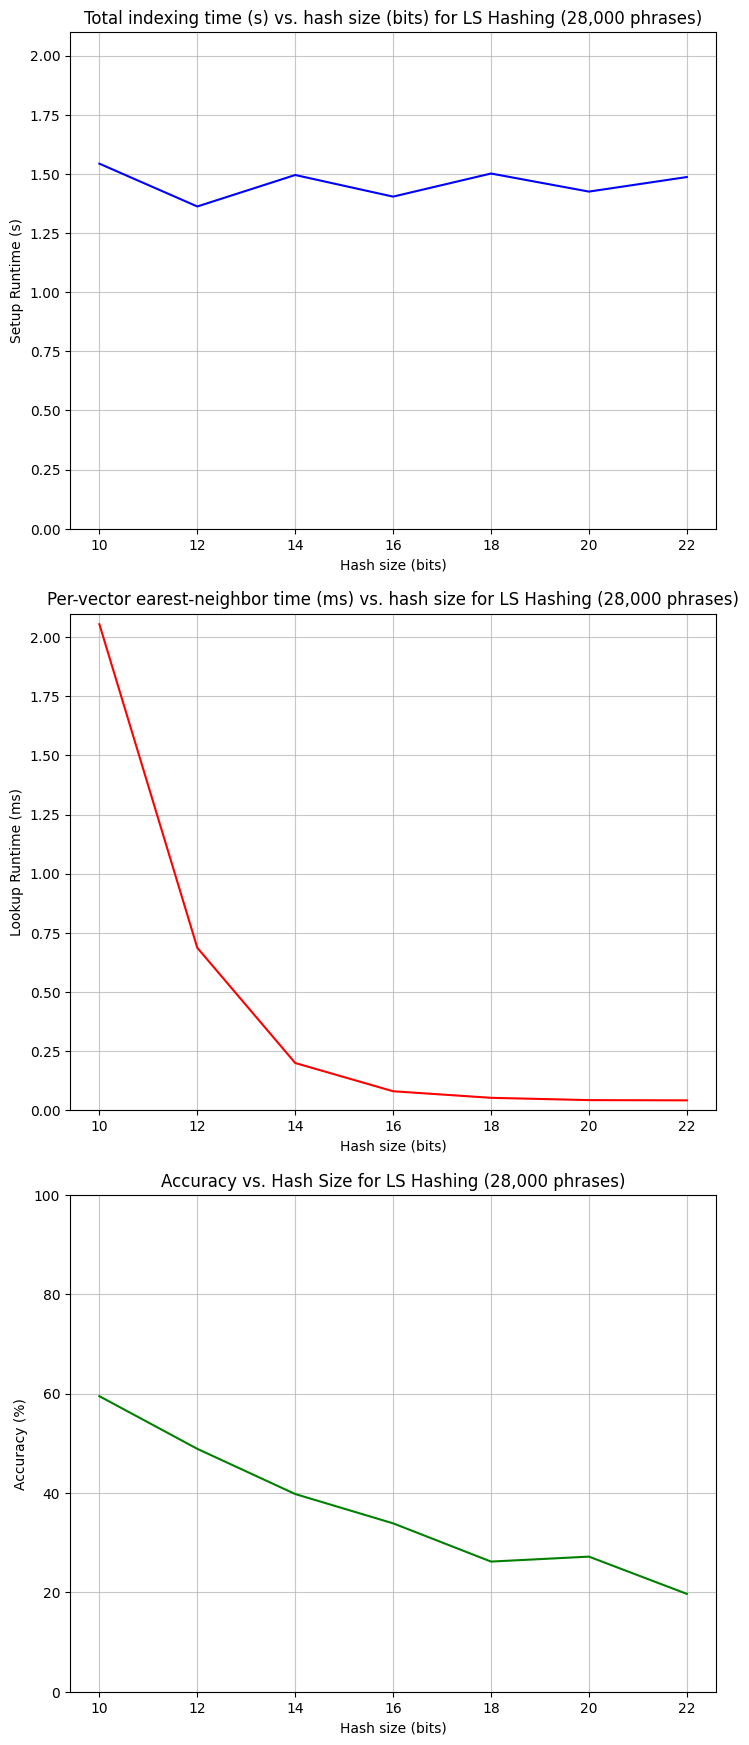

In [242]:
import matplotlib.pyplot as plt

times = []
setup_times = []
hash_size = []
accs = []
for r in res:
    hash_size.append(r[0])
    setup_times.append(r[1])
    times.append(r[2])
    accs.append(r[3] * 100)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,18))
fig.tight_layout(pad=4)
ax1.set_title("Total indexing time (s) vs. hash size (bits) for LS Hashing (28,000 phrases)")
ax2.set_title("Per-vector earest-neighbor time (ms) vs. hash size for LS Hashing (28,000 phrases)")
ax3.set_title("Accuracy vs. Hash Size for LS Hashing (28,000 phrases)")
ax1.plot(hash_size, setup_times, label='Indexing time (s)', color='blue')
ax2.plot(hash_size, times, label='Nearest-neighbor query time (s)', color='red')
ax3.plot(hash_size, accs, label='Accuracy (%)', color='green')
ax1.set_ybound(lower=0.0, upper=2.10)
ax2.set_ybound(lower=0.0, upper=2.10)
ax3.set_ybound(lower=0.0, upper=100.0)
ax2.set_xlabel('Hash size (bits)')
ax1.set_xlabel('Hash size (bits)')
ax3.set_xlabel('Hash size (bits)')
ax1.set_ylabel('Setup Runtime (s)')
ax2.set_ylabel('Lookup Runtime (ms)')
ax3.set_ylabel('Accuracy (%)')
ax1.grid(alpha=0.7)
ax2.grid(alpha=0.7)
ax3.grid(alpha=0.7)
plt.show()

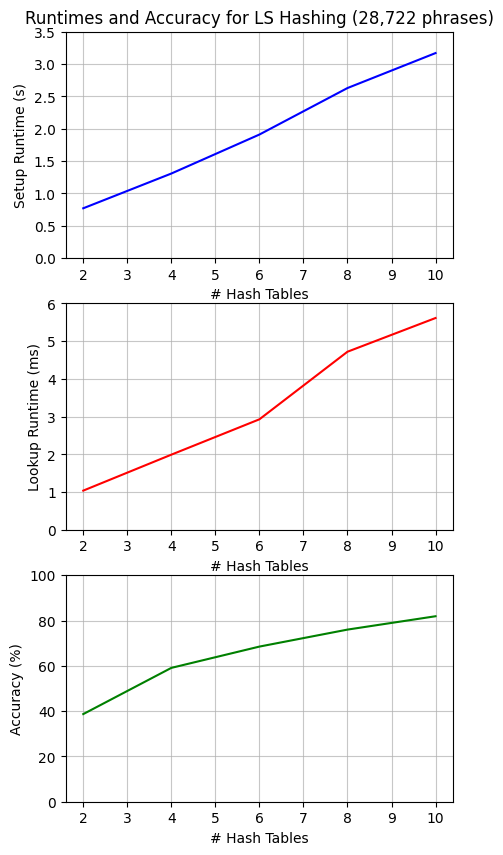

In [216]:
times = []
setup_times = []
hash_tables = []
accs = []
for r in hashres:
    hash_tables.append(r[0])
    setup_times.append(r[1])
    times.append(r[2])
    accs.append(r[3] * 100)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,10))
ax1.set_title("Runtimes and Accuracy for LS Hashing (28,722 phrases)")
ax1.plot(hash_tables, setup_times, label='Setup times', color='blue')
ax2.plot(hash_tables, times, label='Lookup times', color='red')
ax3.plot(hash_tables, accs, label='Accuracy (%)', color='green')
ax2.set_xlabel('# Hash Tables')
ax1.set_xlabel('# Hash Tables')
ax3.set_xlabel('# Hash Tables')
ax1.set_ylabel('Setup Runtime (s)')
ax2.set_ylabel('Lookup Runtime (ms)')
ax3.set_ylabel('Accuracy (%)')
ax1.set_ybound(lower=0.0, upper=3.5)
ax2.set_ybound(lower=0.0, upper=6.0)
ax3.set_ybound(lower=0.0, upper=100.0)
ax1.grid(alpha=0.7)
ax2.grid(alpha=0.7)
ax3.grid(alpha=0.7)
plt.show()

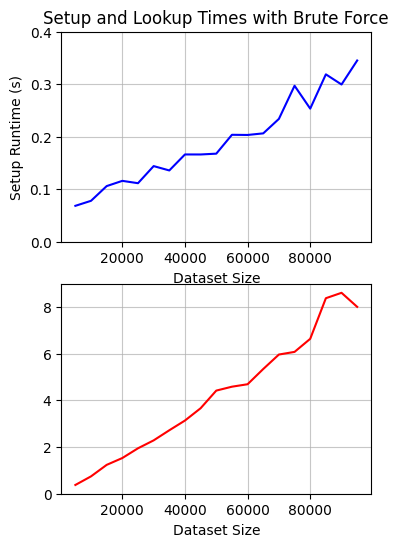

In [215]:
import matplotlib.pyplot as plt
dataset_sizes = []
setup_times = []
times = []
acc = []
for i, r in enumerate(dataset_res):
    dataset_sizes.append(r[0])
    setup_times.append(r[1])
    times.append(r[2])
    acc.append(r[3] * 100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(4,6))
ax1.set_title("Setup and Lookup Times with Brute Force")
ax1.plot(dataset_sizes, times, label='Lookup times', color='blue')
ax2.plot(dataset_sizes, setup_times, label='Setup times', color='red')
ax1.set_xlabel('Dataset Size')
ax2.set_xlabel('Dataset Size')
ax1.set_ylabel('Lookup Runtime (ms)')
ax1.set_ylabel('Setup Runtime (s)')
ax1.set_ybound(lower=0.0, upper=0.4)
ax2.set_ybound(lower=0.0, upper=9.0)
ax1.grid(alpha=0.7)
ax2.grid(alpha=0.7)
plt.show()

/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_41305/2949357139.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_41305/2949357139.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


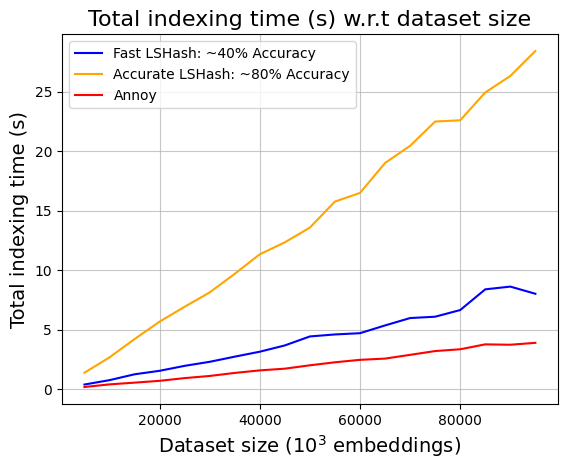

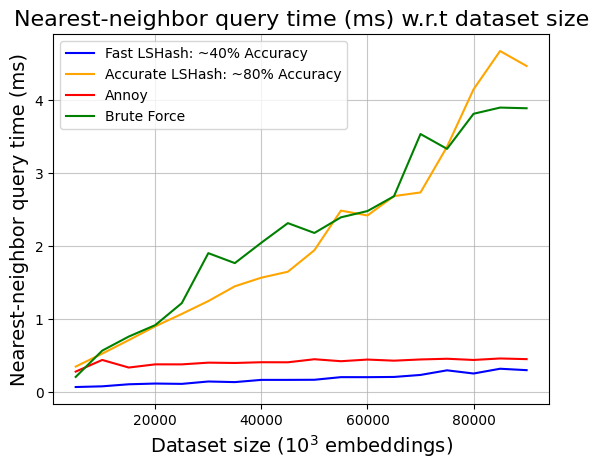

In [362]:
annoyds = np.array([(5000, 0.16629383349936688, 0.2795336670023971, 0.969), (10000, 0.3894469999941066, 0.439292437498807, 0.955), (15000, 0.5337979789983365, 0.33538797949586296, 0.949), (20000, 0.6873567500006175, 0.379025021000416, 0.943), (25000, 0.916602666999097, 0.37875391649868106, 0.945), (30000, 1.0970969999980298, 0.4023228750011185, 0.938), (35000, 1.351890062498569, 0.39791668749967357, 0.923), (40000, 1.5651018540011137, 0.40805949999776203, 0.906), (45000, 1.709484312501445, 0.4073080210000626, 0.906), (50000, 1.9929001040000003, 0.4490706459982903, 0.908), (55000, 2.2460903330065776, 0.42205885449948255, 0.902), (60000, 2.452646646001085, 0.44465512500028126, 0.898), (65000, 2.5566903124999953, 0.4294087915041018, 0.909), (70000, 2.871251812495757, 0.4461399585052277, 0.89), (75000, 3.1913602500062552, 0.4556971665006131, 0.893), (80000, 3.3408399164982256, 0.4392068749948521, 0.897), (85000, 3.753875271002471, 0.4596663955016993, 0.896), (90000, 3.7212147079990245, 0.4503737295017345, 0.884), (95000, 3.8823425829978078, 0.440966729001957, 0.885)])

hashd40 = [(5000, 0.37536399999953574, 0.06837066700245487, 0.421),
 (10000, 0.7442003334945184, 0.07792966699344106, 0.414),
 (15000, 1.2365262500024983, 0.105976646002091, 0.415),
 (20000, 1.5299051250040065, 0.11593981250189245, 0.447),
 (25000, 1.9472631875032675, 0.11147568749584025, 0.445),
 (30000, 2.2862820209993515, 0.14404587500030175, 0.417),
 (35000, 2.719504895998398, 0.13575606249651173, 0.407),
 (40000, 3.13640127099643, 0.16623168750084005, 0.429),
 (45000, 3.664039999996021, 0.16618958349863533, 0.435),
 (50000, 4.419612187499297, 0.16773222900519613, 0.42),
 (55000, 4.586858437498449, 0.20367116649867967, 0.412),
 (60000, 4.692163249994337, 0.20335627099848352, 0.44),
 (65000, 5.3453800000061165, 0.20638693749788217, 0.442),
 (70000, 5.965423520501645, 0.2339793749997625, 0.458),
 (75000, 6.0785447290036245, 0.2970909580035368, 0.437),
 (80000, 6.63888177050103, 0.25349127099616453, 0.402),
 (85000, 8.379411437505041, 0.31881966699438635, 0.429),
 (90000, 8.610479812494304, 0.29947735399764497, 0.419),
 (95000, 8.008495104499161, 0.34519512499537086, 0.423)]
hashd40 = np.array(hashd40)

hashd80 = np.array([(5000, 1.3689077499948326, 0.3480897500048741, 0.793),
 (10000, 2.659377770498395, 0.5260154999996303, 0.792),
 (15000, 4.1971110414961, 0.7109219164995011, 0.775),
 (20000, 5.664800937498512, 0.9008144374965923, 0.796),
 (25000, 6.916719249995367, 1.0698008545004996, 0.792),
 (30000, 8.12299062499369, 1.2461370829987573, 0.792),
 (35000, 9.685011104498699, 1.448795437499939, 0.776),
 (40000, 11.32694160399842, 1.5667424374987604, 0.788),
 (45000, 12.332531521002238, 1.6483933959971182, 0.783),
 (50000, 13.574255854000512, 1.9430068750007194, 0.786),
 (55000, 15.761784062502556, 2.485672708498896, 0.803),
 (60000, 16.485909020499093, 2.4191005414977553, 0.784),
 (65000, 19.00447152099514, 2.684610041498672, 0.782),
 (70000, 20.446673291997286, 2.734710916498443, 0.8),
 (75000, 22.49134789549862, 3.360924750006234, 0.785),
 (80000, 22.594601021002745, 4.147720312503225, 0.795),
 (85000, 24.93607145849819, 4.672553395997966, 0.799),
 (90000, 26.320766854005342, 4.4673833334964, 0.794),
 (95000, 28.418824166998093, 7.535795062496618, 0.79)])

brute = np.array([(5000, 0.20686393066716846, 0.981), (10000, 0.5670526806691972, 0.976), (15000, 0.7597686666704249, 0.976), (20000, 0.9169224446668522, 0.975), (25000, 1.2180590696661966, 0.976), (30000, 1.9028715416643536, 0.975), (35000, 1.766191722335255, 0.975), (40000, 2.0461127083350825, 0.975), (45000, 2.3142080973339034, 0.975), (50000, 2.179429166664098, 0.976), (55000, 2.393789361003049, 0.974), (60000, 2.4796018193349787, 0.973), (65000, 2.6823881806679615, 0.973), (70000, 3.5352473333332455, 0.973), (75000, 3.3318718333369666, 0.973), (80000, 3.8124602220001784, 0.974), (85000, 3.897471708332887, 0.973), (90000, 3.888330388998535, 0.973), (95000, 4.3207341113350894, 0.972)])

dataset_sizes = annoyds[:,0]

setup_hash = hashd40[:,1]
setup_hash80 = hashd80[:,1]
setup_annoy = annoyds[:,1]

lookup_brute = brute[:,1]
lookup_annoy = annoyds[:,2]
lookup_hash = hashd40[:,2]
lookup_hash80 = hashd80[:,2]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
plt.rc('axes', labelsize=14) 
ax1.set_title("Total indexing time (s) w.r.t dataset size", fontdict={"size":16})
ax2.set_title("Nearest-neighbor query time (ms) w.r.t dataset size", fontdict={"size":16})
ax1.plot(dataset_sizes, setup_hash, color="blue", label="Fast LSHash: ~40% Accuracy")
ax1.plot(dataset_sizes, setup_hash80, color="orange", label="Accurate LSHash: ~80% Accuracy")
ax1.plot(dataset_sizes, setup_annoy, color="red", label="Annoy")
ax1.set_xlabel("Dataset size ($10^3$ embeddings)")
ax1.set_ylabel("Total indexing time (s)")
ax2.plot(dataset_sizes[:-1], lookup_hash[:-1], color="blue", label="Fast LSHash: ~40% Accuracy")
ax2.plot(dataset_sizes[:-1], lookup_hash80[:-1], color="orange", label="Accurate LSHash: ~80% Accuracy")
ax2.plot(dataset_sizes[:-1], lookup_annoy[:-1], color="red", label="Annoy")
ax2.plot(dataset_sizes[:-1], lookup_brute[:-1], color="green", label="Brute Force")
ax2.set_xlabel("Dataset size ($10^3$ embeddings)")
ax2.set_ylabel("Nearest-neighbor query time (ms)")
fig1.legend(loc='upper center', bbox_to_anchor=(0.36, 0.88))
fig2.legend(loc='upper center', bbox_to_anchor=(0.36, 0.88))
fig1.show()
fig2.show()
ax1.grid(alpha=0.7)
ax2.grid(alpha=0.7)